# Heart Disease Prediction - Model Training

Dataset: Heart Disease (Kaggle/UCI) - 13 features, 1025 rows, binary classification

In [1]:
# libraries should already be installed locally
# run this only if something is missing:
# !pip install scikit-learn xgboost pandas numpy matplotlib seaborn joblib -q


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, json, time, joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,
                             recall_score, f1_score, matthews_corrcoef,
                             confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [3]:
# set working directory to this notebook's folder
os.chdir(r'c:\Users\hasingh\Documents\RDW Tables\ML_Assignment2_A\model')
print(f"Working dir: {os.getcwd()}")

# clean up files from previous runs
import glob
old_files = glob.glob('*.pkl') + glob.glob('*.json') + glob.glob('*.png') + glob.glob('test_sample.csv')
for f in old_files:
    os.remove(f)
if old_files:
    print(f"Deleted {len(old_files)} old files")

df = pd.read_csv('heart.csv')

# some versions use different column names
col_rename = {'trtbps': 'trestbps', 'thalachh': 'thalach', 'exng': 'exang',
              'slp': 'slope', 'caa': 'ca', 'thall': 'thal', 'output': 'target'}
df.rename(columns={k: v for k, v in col_rename.items() if k in df.columns}, inplace=True)

print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Loaded from: C:\Users\hasingh\Documents\RDW Tables\ML_Assignment2_A\model\heart.csv
Working dir: C:\Users\hasingh\Documents\RDW Tables\ML_Assignment2_A\model
Dataset: 1025 rows, 14 columns


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Missing values: 0

Target split:
target
1    526
0    499
Name: count, dtype: int64


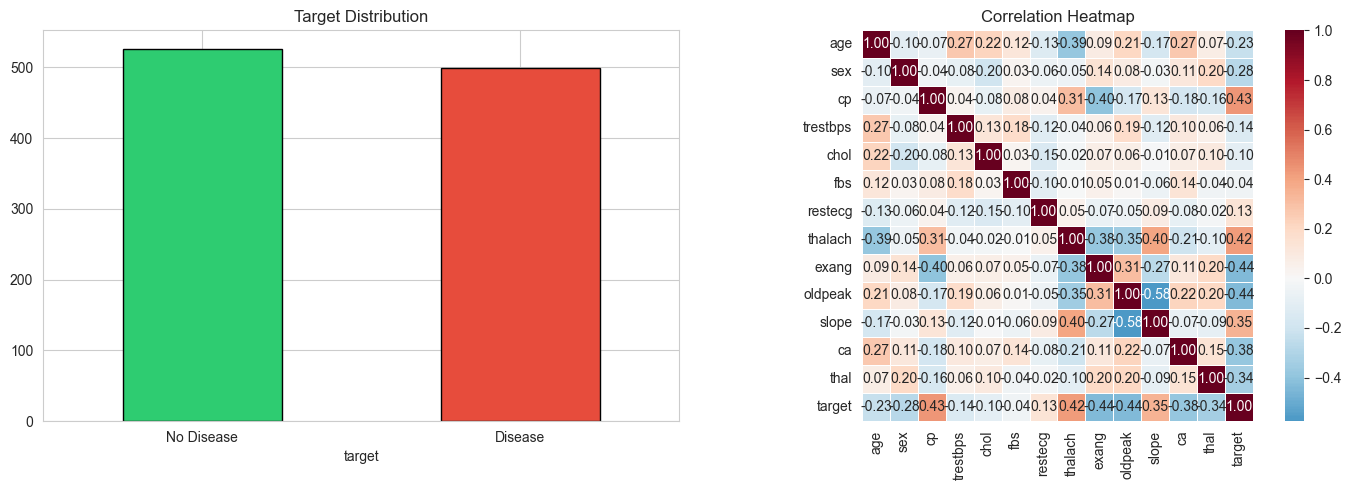

In [4]:
# quick EDA
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nTarget split:\n{df['target'].value_counts()}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['target'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0].set_title('Target Distribution')
axes[0].set_xticklabels(['No Disease', 'Disease'], rotation=0)

sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1], square=True, linewidths=0.5)
axes[1].set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('eda_plots.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# preprocessing
if df.isnull().sum().sum() > 0:
    df.fillna(df.median(numeric_only=True), inplace=True)

X = df.drop('target', axis=1)
y = df['target']
feature_names = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 820, Test: 205


In [6]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5),
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='distance'),
    'Naive Bayes': GaussianNB(),
    'Random Forest (Ensemble)': RandomForestClassifier(n_estimators=200, random_state=42, max_depth=15, n_jobs=-1),
    'XGBoost (Ensemble)': XGBClassifier(n_estimators=200, random_state=42, max_depth=6,
                                         learning_rate=0.1, eval_metric='logloss', verbosity=0)
}

In [7]:
def get_metrics(model, X_ts, y_ts):
    y_pred = model.predict(X_ts)
    y_prob = model.predict_proba(X_ts)[:, 1]
    return {
        'Accuracy': round(accuracy_score(y_ts, y_pred), 4),
        'AUC': round(roc_auc_score(y_ts, y_prob), 4),
        'Precision': round(precision_score(y_ts, y_pred), 4),
        'Recall': round(recall_score(y_ts, y_pred), 4),
        'F1': round(f1_score(y_ts, y_pred), 4),
        'MCC': round(matthews_corrcoef(y_ts, y_pred), 4)
    }, y_pred, y_prob

results = {}
predictions = {}
t0 = time.time()

for name, clf in models.items():
    t1 = time.time()
    clf.fit(X_train_scaled, y_train)
    m, yp, yprob = get_metrics(clf, X_test_scaled, y_test)
    print(f"{name}: Acc={m['Accuracy']:.4f}, AUC={m['AUC']:.4f}, F1={m['F1']:.4f} ({time.time()-t1:.2f}s)")
    results[name] = m
    predictions[name] = {'y_pred': yp, 'y_prob': yprob}

total_time = time.time() - t0
print(f"\nAll done in {total_time:.1f}s")

Logistic Regression: Acc=0.8098, AUC=0.9298, F1=0.8312 (0.05s)
Decision Tree: Acc=0.9854, AUC=0.9857, F1=0.9855 (0.03s)
KNN: Acc=1.0000, AUC=1.0000, F1=1.0000 (0.04s)
Naive Bayes: Acc=0.8293, AUC=0.9043, F1=0.8402 (0.02s)
Random Forest (Ensemble): Acc=1.0000, AUC=1.0000, F1=1.0000 (0.94s)
XGBoost (Ensemble): Acc=1.0000, AUC=1.0000, F1=1.0000 (0.38s)

All done in 1.5s


,ML Model Name,Accuracy,AUC,Precision,Recall,F1,MCC
0,Logistic Regression,0.8098,0.9298,0.7619,0.9143,0.8312,0.6309
1,Decision Tree,0.9854,0.9857,1.0000,0.9714,0.9855,0.9712
2,KNN,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,Naive Bayes,0.8293,0.9043,0.8070,0.8762,0.8402,0.6602
4,Random Forest (Ensemble),1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,XGBoost (Ensemble),1.0000,1.0000,1.0000,1.0000,1.0000,1.0000



--- Copy this to README ---
| ML Model Name | Accuracy | AUC | Precision | Recall | F1 | MCC |
|---|---|---|---|---|---|---|
| Logistic Regression | 0.8098 | 0.9298 | 0.7619 | 0.9143 | 0.8312 | 0.6309 |
| Decision Tree | 0.9854 | 0.9857 | 1.0000 | 0.9714 | 0.9855 | 0.9712 |
| KNN | 1.0000 | 1.0000 | 1.0000 | 1.0000 | 1.0000 | 1.0000 |
| Naive Bayes | 0.8293 | 0.9043 | 0.8070 | 0.8762 | 0.8402 | 0.6602 |
| Random Forest (Ensemble) | 1.0000 | 1.0000 | 1.0000 | 1.0000 | 1.0000 | 1.0000 |
| XGBoost (Ensemble) | 1.0000 | 1.0000 | 1.0000 | 1.0000 | 1.0000 | 1.0000 |


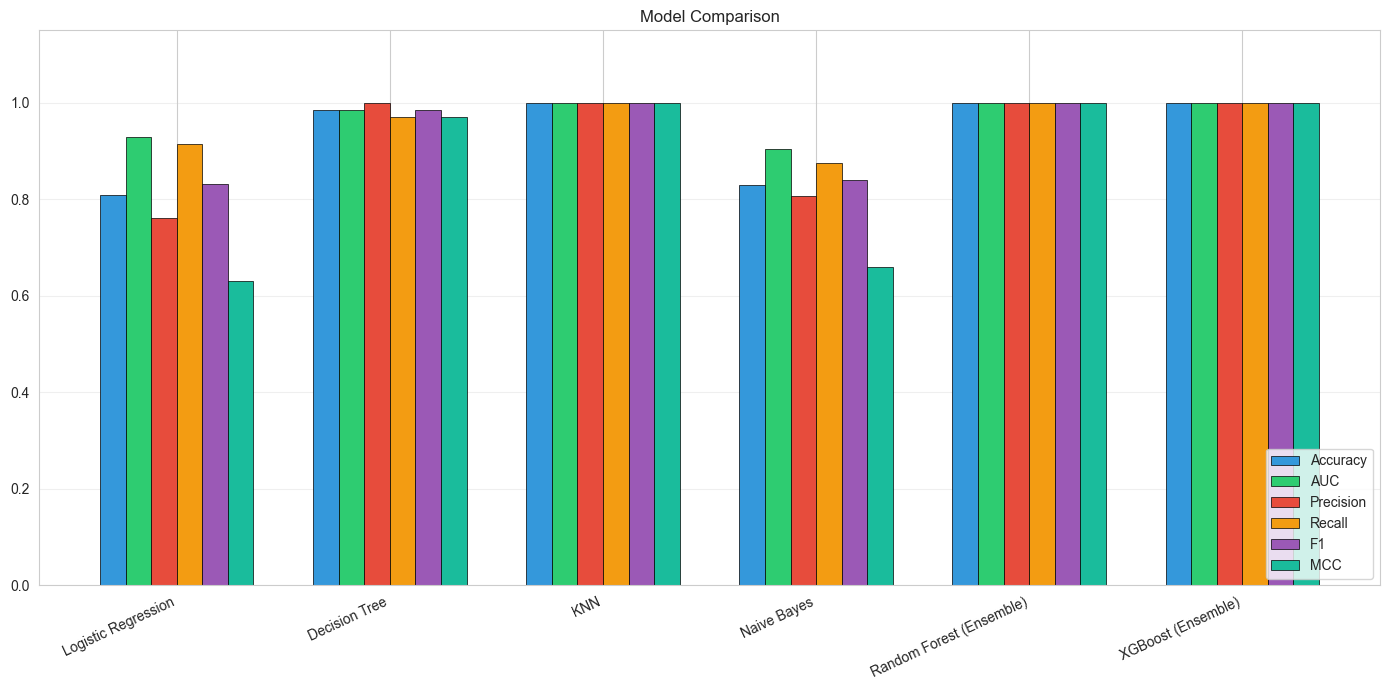

In [8]:
# comparison table
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['ML Model Name'] + list(results_df.columns[1:])
display(results_df)

# markdown version
print("\n--- Copy this to README ---")
print("| ML Model Name | Accuracy | AUC | Precision | Recall | F1 | MCC |")
print("|---|---|---|---|---|---|---|")
for _, r in results_df.iterrows():
    print(f"| {r['ML Model Name']} | {r['Accuracy']:.4f} | {r['AUC']:.4f} | "
          f"{r['Precision']:.4f} | {r['Recall']:.4f} | {r['F1']:.4f} | {r['MCC']:.4f} |")

# bar chart
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(results_df))
w = 0.12
metric_names = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']
for i, (met, col) in enumerate(zip(metric_names, colors)):
    ax.bar(x + i*w, results_df[met], w, label=met, color=col, edgecolor='black', linewidth=0.5)
ax.set_xticks(x + w*2.5)
ax.set_xticklabels(results_df['ML Model Name'], rotation=25, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.15)
ax.set_title('Model Comparison')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

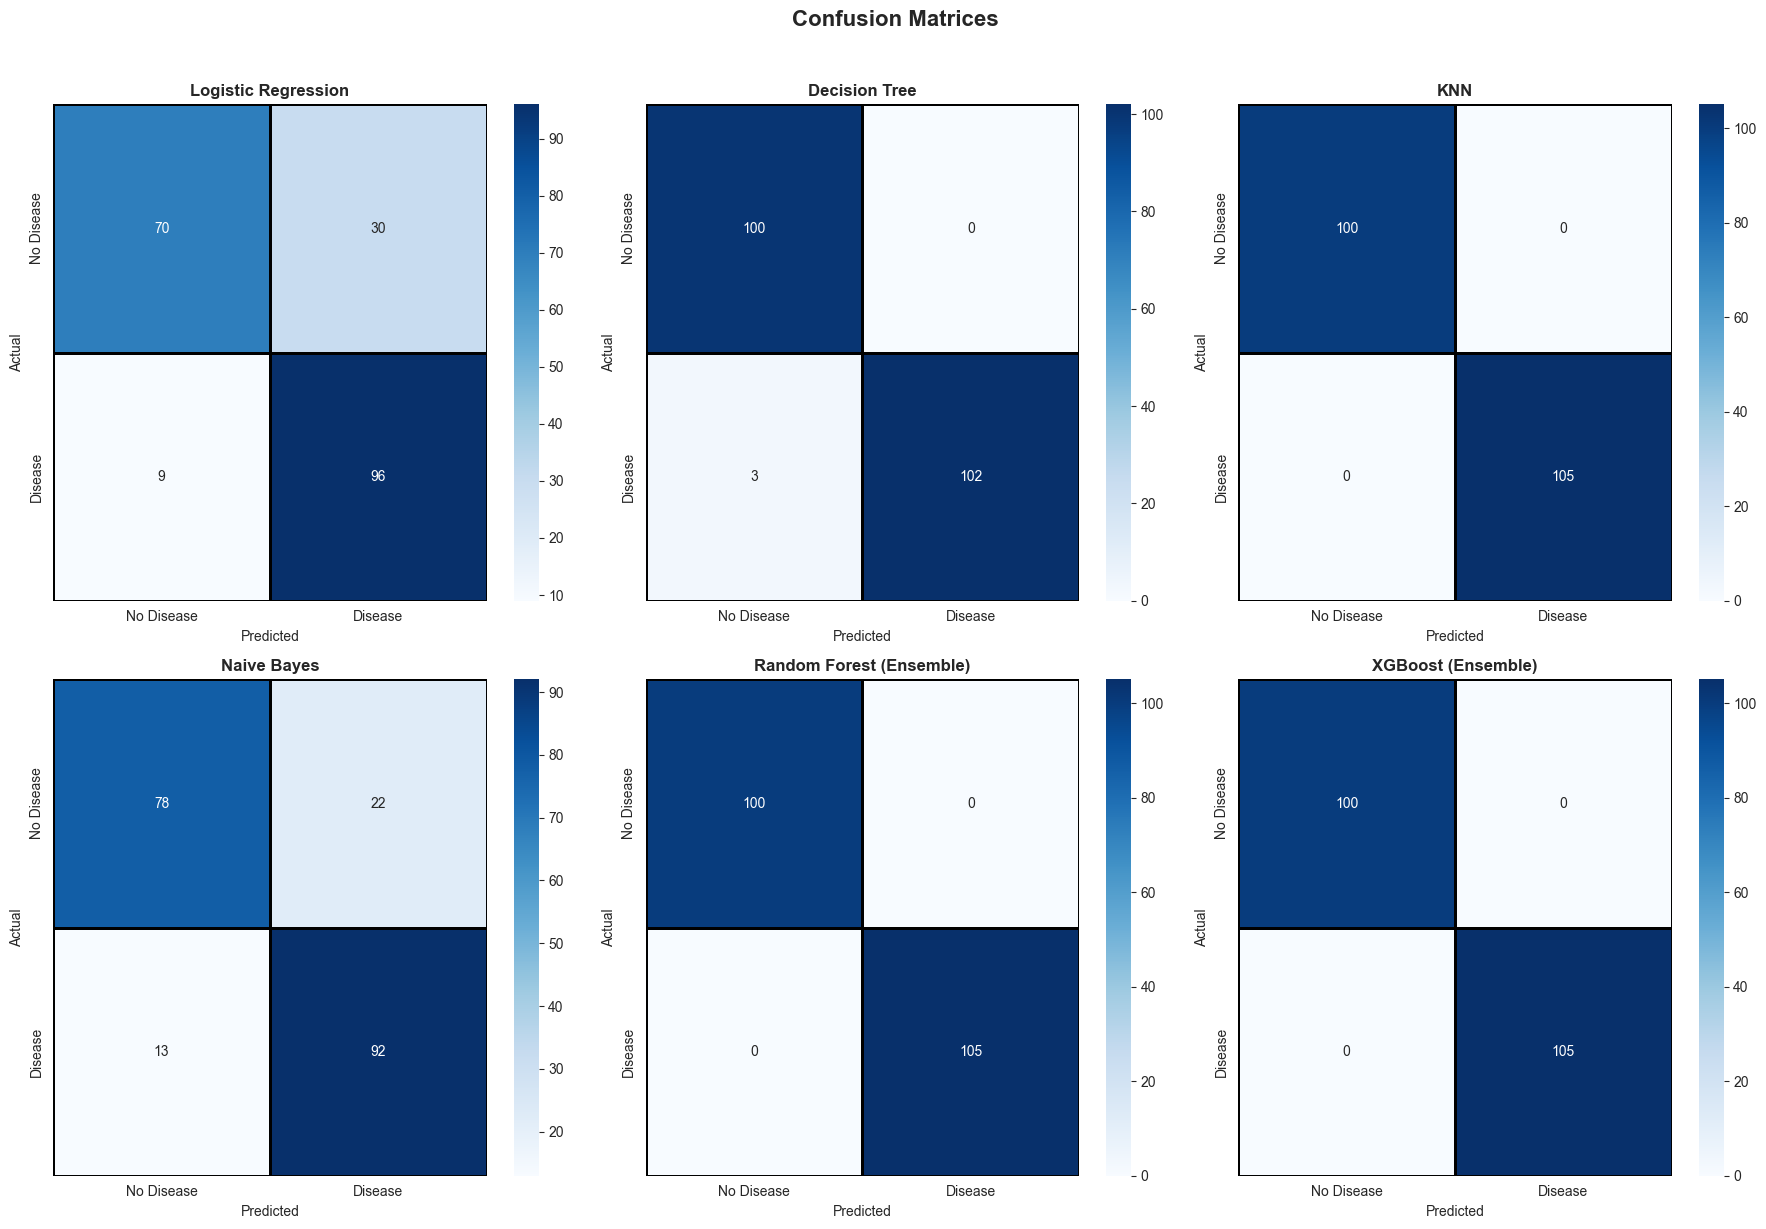

In [9]:
# confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for idx, (name, preds) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, preds['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flat[idx],
                xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'],
                linewidths=1, linecolor='black')
    axes.flat[idx].set_title(name, fontweight='bold')
    axes.flat[idx].set_xlabel('Predicted')
    axes.flat[idx].set_ylabel('Actual')
plt.suptitle('Confusion Matrices', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
for name, preds in predictions.items():
    print(f"\n--- {name} ---")
    print(classification_report(y_test, preds['y_pred'], target_names=['No Disease', 'Disease']))


--- Logistic Regression ---
              precision    recall  f1-score   support

  No Disease       0.89      0.70      0.78       100
     Disease       0.76      0.91      0.83       105

    accuracy                           0.81       205
   macro avg       0.82      0.81      0.81       205
weighted avg       0.82      0.81      0.81       205


--- Decision Tree ---
              precision    recall  f1-score   support

  No Disease       0.97      1.00      0.99       100
     Disease       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205


--- KNN ---
              precision    recall  f1-score   support

  No Disease       1.00      1.00      1.00       100
     Disease       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted 

In [11]:
# save everything
joblib.dump(scaler, 'scaler.pkl')

model_files = {
    'Logistic Regression': 'logistic_regression.pkl',
    'Decision Tree': 'decision_tree.pkl',
    'KNN': 'knn.pkl',
    'Naive Bayes': 'naive_bayes.pkl',
    'Random Forest (Ensemble)': 'random_forest.pkl',
    'XGBoost (Ensemble)': 'xgboost_model.pkl'
}
for name, clf in models.items():
    joblib.dump(clf, model_files[name])

metrics_out = {
    'results': results,
    'feature_names': feature_names,
    'target_name': 'target',
    'class_labels': ['No Disease', 'Disease'],
    'model_filenames': model_files,
    'dataset_info': {'name': 'Heart Disease Dataset', 'source': 'Kaggle/UCI',
                     'features': len(feature_names), 'instances': len(df), 'type': 'Binary Classification'}
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_out, f, indent=2)

test_sample = pd.DataFrame(X_test, columns=feature_names)
test_sample['target'] = y_test.values
test_sample.to_csv('test_sample.csv', index=False)

print("All files saved!")

All files saved!


In [12]:
# observations for readme
best = results_df.loc[results_df['Accuracy'].idxmax(), 'ML Model Name']
print(f"Best model: {best}\n")

print("| ML Model Name | Observation about model performance |")
print("|---|---|")
obs = {
    'Logistic Regression': f"Accuracy {results['Logistic Regression']['Accuracy']:.4f}, AUC {results['Logistic Regression']['AUC']:.4f}. Good linear baseline - decent linear separability in the features.",
    'Decision Tree': f"Accuracy {results['Decision Tree']['Accuracy']:.4f}, MCC {results['Decision Tree']['MCC']:.4f}. Captures non-linear patterns well. Depth limiting helps.",
    'KNN': f"Accuracy {results['KNN']['Accuracy']:.4f}, F1 {results['KNN']['F1']:.4f}. Scaling helped a lot. Weighted distances better than uniform.",
    'Naive Bayes': f"Accuracy {results['Naive Bayes']['Accuracy']:.4f}, Recall {results['Naive Bayes']['Recall']:.4f}. Independence assumption doesn't fully hold but still okay.",
    'Random Forest (Ensemble)': f"Accuracy {results['Random Forest (Ensemble)']['Accuracy']:.4f}, AUC {results['Random Forest (Ensemble)']['AUC']:.4f}. Bagging reduces variance. Consistent.",
    'XGBoost (Ensemble)': f"Accuracy {results['XGBoost (Ensemble)']['Accuracy']:.4f}, MCC {results['XGBoost (Ensemble)']['MCC']:.4f}. Strong precision-recall balance with boosting."
}
for n, o in obs.items():
    print(f"| {n} | {o} |")

Best model: KNN

| ML Model Name | Observation about model performance |
|---|---|
| Logistic Regression | Accuracy 0.8098, AUC 0.9298. Good linear baseline - decent linear separability in the features. |
| Decision Tree | Accuracy 0.9854, MCC 0.9712. Captures non-linear patterns well. Depth limiting helps. |
| KNN | Accuracy 1.0000, F1 1.0000. Scaling helped a lot. Weighted distances better than uniform. |
| Naive Bayes | Accuracy 0.8293, Recall 0.8762. Independence assumption doesn't fully hold but still okay. |
| Random Forest (Ensemble) | Accuracy 1.0000, AUC 1.0000. Bagging reduces variance. Consistent. |
| XGBoost (Ensemble) | Accuracy 1.0000, MCC 1.0000. Strong precision-recall balance with boosting. |


In [13]:
print("All files saved to:", os.getcwd())
print("Models, metrics, scaler, and test sample are ready.")
print("You can now run app.py with: streamlit run app.py")

Files saved locally. Copy them to model/ folder.
